<a href="https://colab.research.google.com/github/Ankur-singh/UnderstandingLLMs/blob/main/nbs/Rotary%20Position%20Embedding%20(RoPE).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Rotary Position Embedding (RoPE)

After listening to Umar Jamil’s [talk](https://www.youtube.com/live/4O-t7SwArkI?si=Vrf8kaCLn6LFB_bg) on **GPU Mode**, I was really inspired. I think it was one of the best talks debunking his mindset behind learning and producing super high-quality content. I decided to apply his approach to learning and gaining a deeper understanding of various LLM components.

In another part of my life, I was working on a PR to add LongRoPE support for Phi3-mini-128k in [torchtune](https://github.com/pytorch/torchtune). I referred to multiple **LongRoPE** implementations—both within torchtune and in external projects—but I just couldn’t get it to work.

So, after the talk, I thought: Huh 🤔, let me start with RoPE. I’ll learn it the hard way—going through the paper, implementing it from scratch, then studying other people's implementations. Only after fully understanding it (i.e., being able to implement all of it from scratch) will I say that I truly know and understand RoPE. From there, I’ll build up to LongRoPE.

This notebook serves as a **logbook**, documenting everything I learn on this adventurous journey to understanding RoPE from the ground up.

## Reading RoPE paper (aka [RoFormer](https://arxiv.org/pdf/2104.09864))

Following the technique outlined by Umar, I started by reading the **Abstract**, **Introduction**, and **Conclusion**, highlighting key points. This is a great way to gain a high-level understanding and prepares you for what to expect from the paper. Here are some important highlights from these sections:  

- **RoPE** encodes absolute position using a **rotation matrix** while incorporating explicit **relative position dependency** in the self-attention formulation.  
- **RoPE** has several valuable and desirable properties, including:  
  - **Sequence length flexibility**  
  - **Decaying inter-token dependency** with increasing relative distances  
  - The capability to equip **linear self-attention** (see [LinFormer](https://arxiv.org/abs/2006.04768)) with **relative position encoding**  
- The key idea is to encode **relative position** by multiplying context representations with a **rotation matrix**.  
- With absolute position information encoded through a **rotation matrix**, relative position can be naturally formulated using **vector projection** in self-attention.

For the math part, it's highly recommended to use **pen and paper**—write down the equations and work through the derivations. **TBH**, I still don’t fully understand all the mathematics in the **RoFormer** paper. But the process of writing things down forces your brain to pick up details that it wouldn’t through passive reading.  

Here are a few minor things I picked up:  

- **Absolute Position Embeddings**, whether from a **predefined sinusoidal function** (as in the original Transformer by Vaswani et al.) or as **trainable vectors**, add position information to all **q**, **k**, and **v** vectors. Look at the subscript of function \( $f$ \).



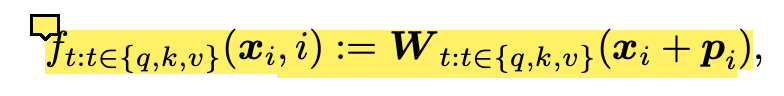

- (Almost all) **Relative Position Embeddings** add position information to only **k** and **v** vectors.

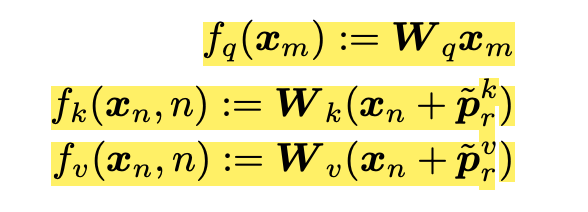

- Finally, **RoPE** adds position information to only **q** and **k**, not the **v** vector.

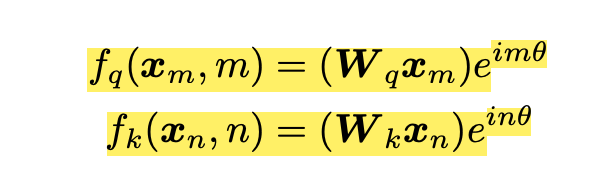

Another important difference here is that both **absolute** and **relative** methods **add** position encoding to the context representations. However, **RoPE** **multiplies** position encoding and context representation. This point is emphasized repeatedly in the paper, but writing it down on paper really helped solidify it for me.

These differences are subtle but quite important to fully understand and appreciate **RoPE**. After picking up on these subtle distinctions, I went through the paper again, looking for the authors' motivation for making these choices. Here is an excerpt from *Section 3.1* in the paper:  

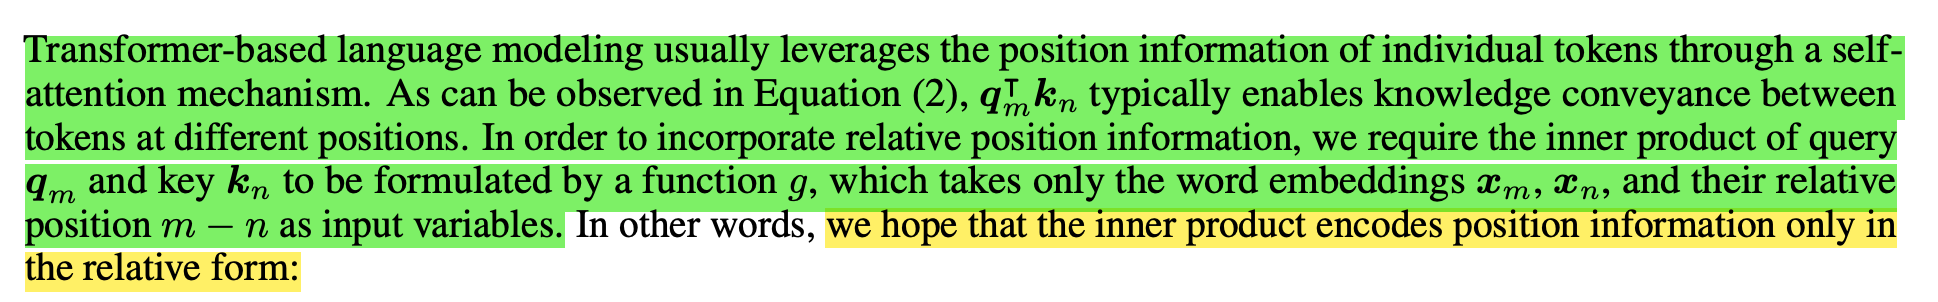

- **Sentence 1 & 2**: Since positional information is leveraged in the self-attention mechanism, particularly in the \( $q_m^T k_n$ \) operation, the authors decided to update only the **q** and **k** vectors with position information.  
- **Sentence 3**: With all the relative embedding papers, the benefits of relative position encoding were clear. So, they chose to use only relative position information during the inner product of the **query** and **key** vectors.

Looks like the authors are some sort of math ninjas—they quickly provide the solution (i.e., the mathematical transformation that meets both constraints). Here is the solution for the 2D case:  

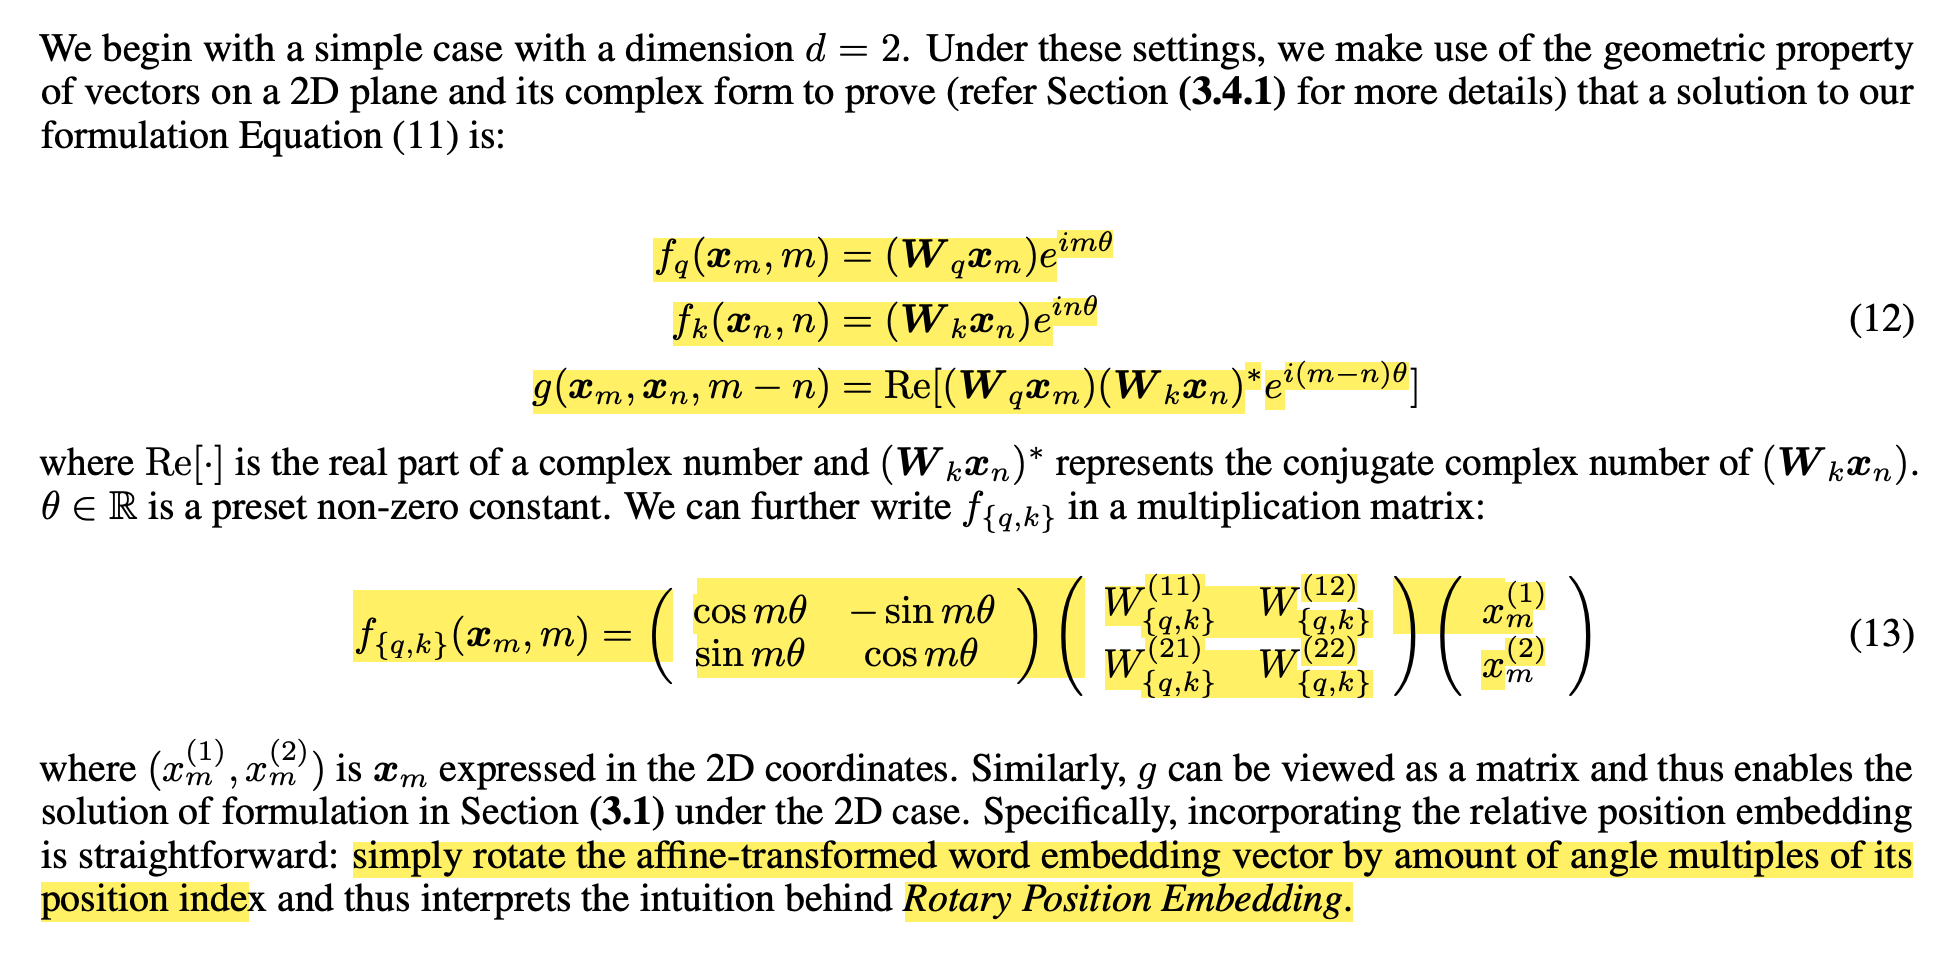

Here is the general form of the solution:  

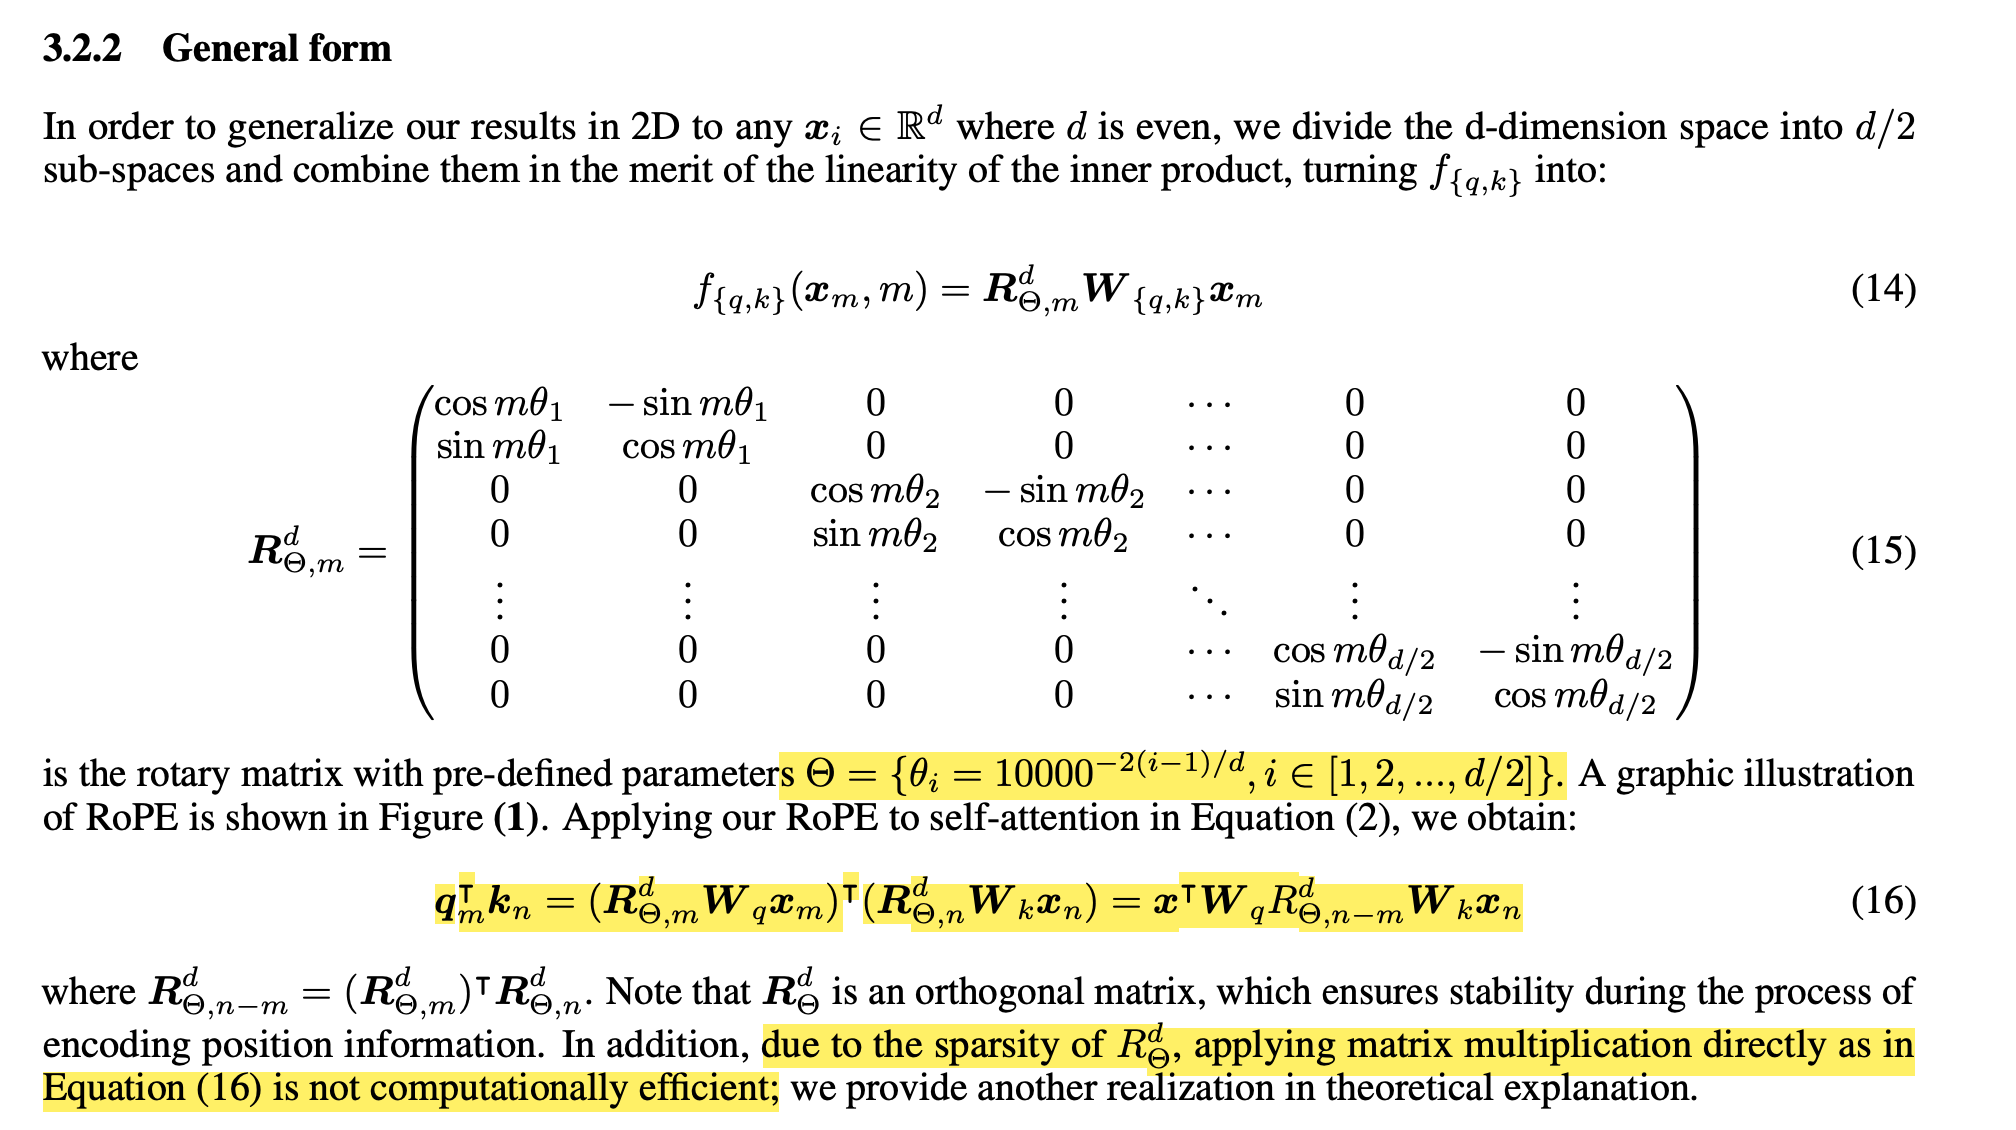

Just after presenting the general form solution, the authors quickly point out that due to sparsity, applying matrix multiplication directly is not very computationally efficient (see the last two lines in the above image). They also present a more computationally efficient realization.

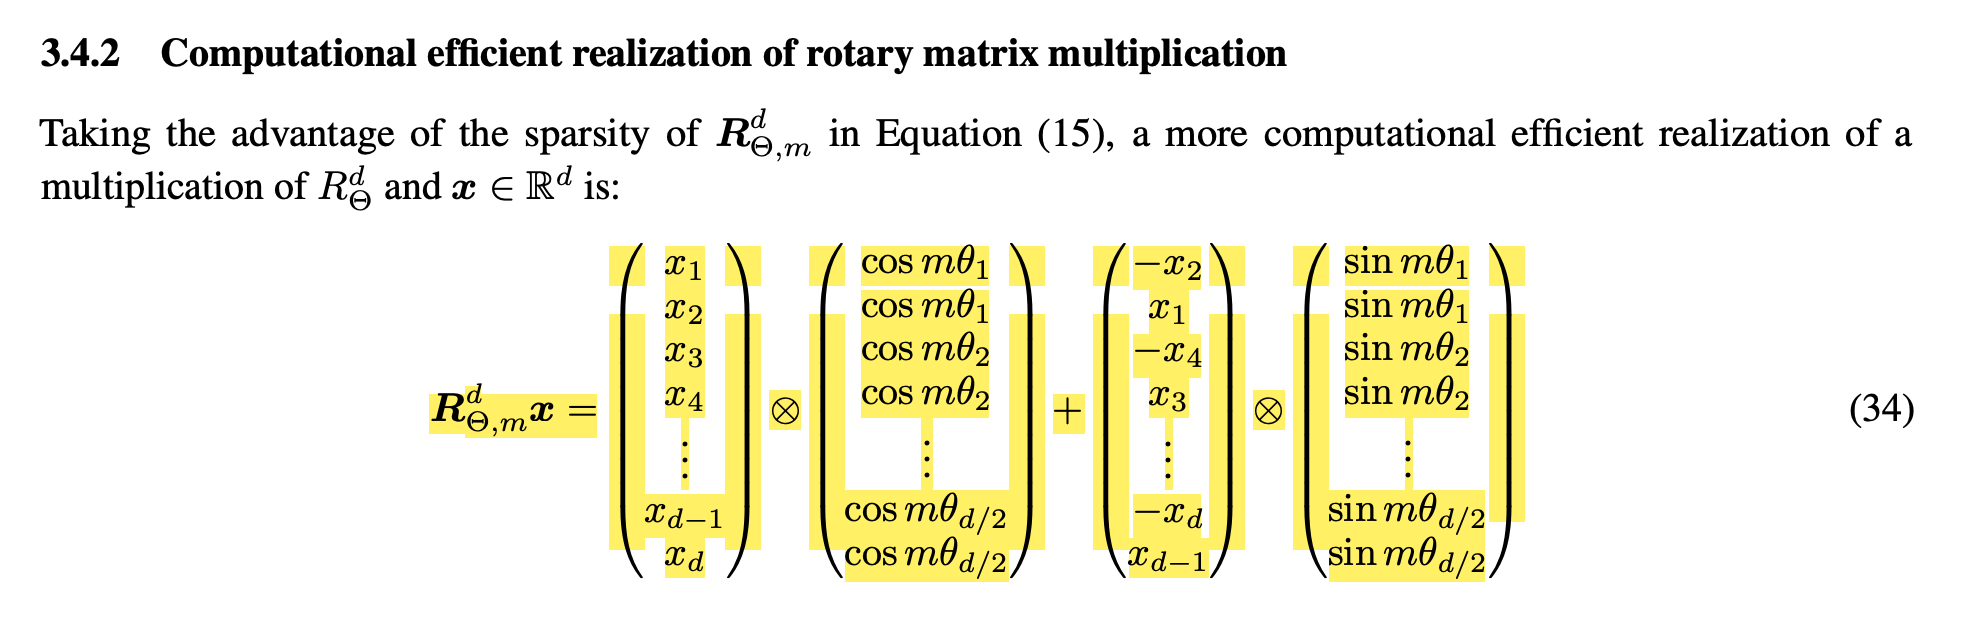

Equipped with all this information, I was eager to implement **RoPE** in PyTorch. But before I jump to the next section, here are three important lessons when reading the paper:

1. For theoretical sections like the **abstract**, **introduction**, and **conclusion**, highlight key points as you read.
2. For the **mathematics**, use **pen and paper**. Highly recommended!
3. **Re-read** the paper a few times.

## Implementing RoPE

In [5]:
import torch

# batch_size, seq_len, dim
B, S, D = 4, 8, 128
x = torch.randn(B, S, D)

# RoPE initializations
base = 10_000


def get_theta(S, D):
    pos_ids = torch.arange(S, dtype=torch.float)
    freqs = base ** (torch.arange(0, D, 2) / D)
    theta = torch.outer(pos_ids, 1.0/freqs)
    return theta

print(f"{x.shape=}")
theta = get_theta(S,D)
print(f"{theta.shape=}")

x.shape=torch.Size([4, 8, 128])
theta.shape=torch.Size([8, 64])


### Compute Efficient Implementation (based on Equation 34)

Below is a naive one-to-one implementation of the computationally efficient realization of the rotary matrix based on equation 34 from the paper. Let me jot down the steps:

1. Calculate **`freqs`** ($\theta$) and **`pos_ids`** ($m$)
2. Take the outer product to get a matrix of all $m\theta$ pairs
3. Duplicate **$\theta$** values and rearrange them
4. Calculate $cos$ and $sin$
5. Calculate the transformed ($x\_half$) vector in the second half of the equation
6. Finally, calculate the rotated vector using $x = (x * \cos m\theta) + (x\_half * \sin m\theta)$

In [13]:
def apply_rope34(x):
    _, S, D = x.shape

    # [mθ1, mθ2, mθ3, mθ4, . . . mθ(d//2)] | Shape: [seq_len, dim//2]
    theta = get_theta(S, D)

    # [batch, seq_len, dim//2]
    sin, cos = theta.sin(), theta.cos()

    # Expand [t1, t2, t3, t4] -> [t1, t1, t2, t2, t3, t3, t4, t4]
    sin_pos = torch.stack([sin, sin], dim=-1).view(S, D)
    cos_pos = torch.stack([cos, cos], dim=-1).view(S, D)

    # 2nd term: [-x2, x1, -x4, x3, -x6, x5, -x8, x7]
    x_half = torch.stack([-x[..., 1::2], x[..., 0::2]], dim=-1).reshape_as(x)

    x_rot = x * cos_pos + x_half * sin_pos
    return x_rot

In [15]:
x_rotated = apply_rope34(x)
print(f"{x.shape=}")
print(f"{x_rotated.shape=}") # same shape as `x`

x.shape=torch.Size([4, 8, 128])
x_rotated.shape=torch.Size([4, 8, 128])


The above code is similar to the **RoFormer** implementation in the [**transformers** library](https://github.com/huggingface/transformers/blob/v4.49.0/src/transformers/models/roformer/modeling_roformer.py#L309).


### Simplified 2D Implementation (based on equation 13)

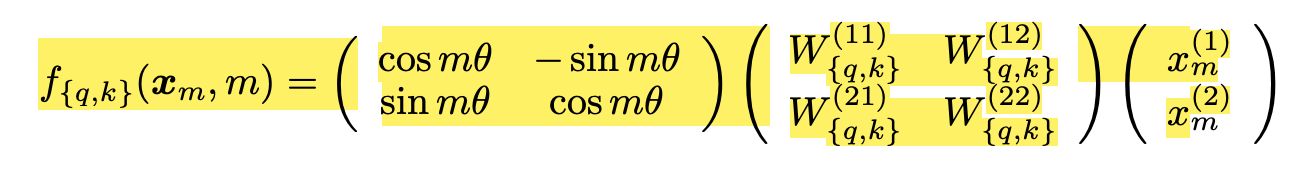

If we assume that the embedding $x$ is already multiplied with the $Q$ and $K$ matrices, then we can simplify the above equation as follows:

\begin{align}
    f(x_m, m) = \begin{pmatrix}
    \cos m\theta & \sin m\theta \\
    \sin m\theta & \cos m\theta
    \end{pmatrix} \begin{pmatrix}
    x_1 \\ x_2
    \end{pmatrix}
    &= \begin{pmatrix}
    x_1 * \cos m\theta - x_2 * \sin m\theta \\
    x_1 * \sin m\theta - x_2 * \cos m\theta
    \end{pmatrix}
\end{align}

Here’s what the code implementation looks like:

In [17]:
def apply_rope13(x):
    _, S, D = x.shape

    # [mθ1, mθ2, mθ3, mθ4, . . . mθ(d//2)] | Shape: [seq_len, dim//2]
    theta = get_theta(S, D)

    # [batch, seq_len, dim//2]
    sin, cos = theta.sin(), theta.cos()

    # even and odd terms
    x1, x2 = x[..., 0::2], x[..., 1::2]

    # [cos_nθ, -sin_nθ] [x1]
    # [sin_nθ,  cos_nθ] [x2]
    # => [x1 * cos_nθ - x2 * sin_nθ, x1 * sin_nθ + x2 * cos_nθ]
    x_rot = torch.stack([x1 * cos - x2 * sin, x1 * sin + x2 * cos], dim=-1).reshape_as(x)
    return x_rot

In [18]:
x_rotated = apply_rope13(x)
print(f"{x.shape=}")
print(f"{x_rotated.shape=}") # same shape as `x`

x.shape=torch.Size([4, 8, 128])
x_rotated.shape=torch.Size([4, 8, 128])


In [26]:
# Both implementation should produce same result
assert torch.allclose(apply_rope34(x), apply_rope13(x)), "Not Equal"

In this approach, we don’t have to duplicate `theta`. Ideally, this should save some memory. The official [RoFormer PyTorch](https://github.com/JunnYu/RoFormer_pytorch) repo inspired the above implementation.


### Llama3.1 Implementation


Most RoPE implementations I found online makes use one of the two implementations above. But RoPE implementation in Meta Llama3.1 implements RoPE directly using equation 12 with complex number mathematics. While It might sound complex, but the code is pretty concise.

In [21]:
def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    ndim = x.ndim
    assert 0 <= 1 < ndim
    assert freqs_cis.shape == (x.shape[1], x.shape[-1])
    shape = [d if i == 1 or i == ndim - 1 else 1 for i, d in enumerate(x.shape)]
    return freqs_cis.view(*shape)

def apply_rope_llama31(x):
    _, S, D = x.shape

    # [mθ1, mθ2, mθ3, mθ4, . . . mθ(d//2)] | Shape: [seq_len, dim//2]
    theta = get_theta(S, D)

    # constructs a complex tensor from polar coordinates
    freq_cis = torch.polar(torch.ones_like(theta), theta)

    # turn `x` into complex number
    x_ = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2))
    freq_cis = reshape_for_broadcast(freq_cis, x_)

    # Real[X * e^(imθ)]
    x_rotated = torch.view_as_real(x_ * freq_cis).flatten(-2)
    return x_rotated

In [22]:
x_rotated = apply_rope_llama31(x)
print(f"{x.shape=}")
print(f"{x_rotated.shape=}") # same shape as `x`

x.shape=torch.Size([4, 8, 128])
x_rotated.shape=torch.Size([4, 8, 128])


In [25]:
# should be equal to other two implementations
assert torch.allclose(apply_rope_llama31(x), apply_rope13(x)), "Not Equal"
assert torch.allclose(apply_rope_llama31(x), apply_rope34(x)), "Not Equal"

The complete code can be found here: [Llama3.1 RoPE implementation](https://github.com/meta-llama/llama-models/blob/f45cdfd624b98b6655540f7101d8d9cb432e631c/models/llama3_1/reference_impl/model.py#L90). Also, Umar Jamil has this amazing [YouTube video](https://youtu.be/Mn_9W1nCFLo?si=nSIT5--ZsFejUyF6) where he codes Llama2 from scratch, implementing RoPE step-by-step.

The last objective was to check out the HF implementation and call it a day. But I didn’t know what I was stepping into.

### HuggingFace implementation

I decided to look at the RoPE implementation in the [Llama model](https://github.com/huggingface/transformers/blob/main/src/transformers/models/llama/modeling_llama.py). Their implementation was very similar to our [equation 34 implementation](#scrollTo=z7tkI14tVg57&line=1&uniqifier=1), where we duplicated `theta`, calculated `cos`, `sin`, and `x_half`, and finally combined them to derive `x_rotated`.

But there was one subtle difference in how they calculated `x_half`. Here is the [code snippet](https://github.com/huggingface/transformers/blob/2256875a77df7819499d1cf1076e44af048f1439/src/transformers/models/llama/modeling_llama.py#L151C1-L155C40):

```python
def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)
```

Instead of taking even and odd indexes, they simply take the first and second halves. My initial thought was, "This seems wrong," but if that were the case, others would have noticed it. Maybe I’m missing something. So, I extracted the relevant parts and compared them with my implementation. The results didn’t match.

My next hunch was that they might have used some combination of *reshape*, *transpose*, and *broadcast* to do it and still get the same results. But why? My guess was **performance**!

I started hunting for these magic transformations in the codebase. After wasting a couple of hours looking through the code, copy-pasting, writing code, and seeking help from LLMs (conversation link: [ChatGPT](https://chatgpt.com/share/67d835d4-e934-8009-bccf-b81fe80cc507) & [Claude](https://claude.ai/share/f0c50069-d1d9-49b8-b5c8-7d197be3cab8)), I became sure that the HF implementation was wrong (even though it’s very unlikely).

The next step was to create an issue, but being a good open-source contributor and to avoid duplication, I decided to first search for it. I realized that many people before me had the same realization. [Here](https://github.com/huggingface/transformers/issues/25199) is one such issue with an in-depth discussion and numerous resources. TL;DR: [comment](https://discuss.huggingface.co/t/is-llama-rotary-embedding-implementation-correct/44509/9).

Basically, when adding any model to the Transformers library, one has to include a `convert_xxxx_weights_to_hf.py` script. This script converts the original weight and layer names to fit the HF convention. The common belief is that weights should not be changed. But the [convert script](https://github.com/huggingface/transformers/blob/main/src/transformers/models/llama/convert_llama_weights_to_hf.py) for Llama has a `premute` function that rearranges the weights:

```python
# permute for sliced rotary
def permute(w, n_heads, dim1=dim, dim2=dim):
    return w.view(n_heads, dim1 // n_heads // 2, 2, dim2).transpose(1, 2).reshape(dim1, dim2)
```

This re-arrangement is what allows them to use `x[..., :D/2]` and `x[..., D/2:]` in the RoPE operation, rather than splitting \(x\) by even and odd indices. Therefore, my guess was right—they do have the magic transformation that I was looking for, but it’s not in the training/inference code, it’s in the convert script. This can be a source of confusion, as it’s not very well documented and is located in a completely different part of the codebase.

This discovery was a fantastic outcome that truly validated my understanding of RoPE. It was a subtle, latent finding that confirmed my thought process and added a layer of depth to my comprehension. The whole journey was a thrilling adventure filled with learning, and I thoroughly enjoyed the process. It’s a perfect example of how diving deep into a problem not only strengthens your expertise but also makes the journey of discovery incredibly fun.

## Further Work

Next, I plan to dive deeper into various ways of extending context window in LLMs, built on top RoPE. Goal is to gain a more comprehensive understanding of RoPE by exploring it from various perspectives. I believe this will provide valuable insights that will make it easier to further advance my knowledge in this area.